In [3]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%%time
zip_path = '/content/drive/My Drive/Colab Notebooks/allimgs_face2.zip'
!cp "{zip_path}" .
!unzip -q allimgs_face2.zip 
!rm allimgs_face2.zip

replace allimgs_face/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
CPU times: user 73.2 ms, sys: 22.6 ms, total: 95.8 ms
Wall time: 19.8 s


In [0]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image
from torchvision import datasets, models, transforms
from torch import nn
import pickle as pl



#Using VGG-19 pretrained model for image classification

model = models.resnet50(pretrained = True)
# model.fc = nn.Sequential(
#     nn.Dropout(0.7),
#     nn.Linear(2048, 1024),
#     nn.Dropout(0.8),
#     nn.Linear(1024, 1),
#     nn.Sigmoid()
# )
# weights = torch.load('/content/drive/My Drive/Colab Notebooks/model weights/vggface_resnet_3conv_best.pl', map_location=torch.device('cpu'))
# weights = torch.load('/content/drive/My Drive/Colab Notebooks/model weights/imagenet_resnet_3conv_best.pl', map_location=torch.device('cpu'))
# weights = pl.load( open( "/content/drive/My Drive/Colab Notebooks/resnet50_ft_weight.pkl", "rb" ))
# model.load_state_dict(weights)

# model.fc = nn.Sequential(
#     nn.Dropout(0.7),
#     nn.Linear(2048, 1024),
# )
for param in model.parameters():
    param.requires_grad = False

In [0]:
#  https://medium.com/datadriveninvestor/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

# img = Image.open('/content/allimgs_face/Scott Walker GOP/google_Scott Walker GOP1.jpeg')
# img = Image.open('/content/allimgs_face/John Zak Woodcock Labour/wiki_John Zak Woodcock Labour1.jpeg')
# img = Image.open('/content/allimgs_face/Conservative Tom Lukiwski/google_Conservative Tom Lukiwski8.jpeg')
img = Image.open('/content/allimgs_face/Danus Skene Scottish National Party/danno-K2000-e1462529364313.jpg')
# img = Image.open('/content/allimgs_face/Dave Brat GOP/google_Dave Brat GOP4.jpeg')
# img = Image.open('/content/allimgs_face/David Rowntree Labour/bing_David Rowntree Labour3.jpeg')




def preprocess(image, size=256):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

'''
    Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)
'''
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)


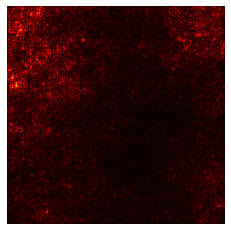

In [30]:
# preprocess the image
X = preprocess(img)

# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()



scores = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]


score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

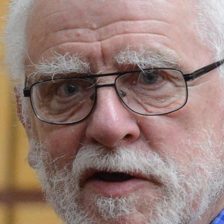

In [31]:
img = img.resize((224,224))
img

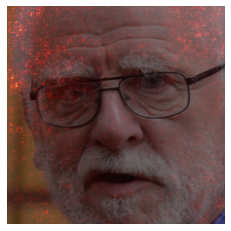

In [32]:
def func3(x, y):
    return (1 - x / 2 + x**5 + y**3) * np.exp(-(x**2 + y**2))


# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

x = np.arange(-3.0, 3.0, dx)
y = np.arange(-3.0, 3.0, dy)
X, Y = np.meshgrid(x, y)

# when layering multiple images, the images need to have the same
# extent.  This does not mean they need to have the same shape, but
# they both need to render to the same coordinate system determined by
# xmin, xmax, ymin, ymax.  Note if you use different interpolations
# for the images their apparent extent could be different due to
# interpolation edge effects

extent = np.min(x), np.max(x), np.min(y), np.max(y)
fig = plt.figure(frameon=False)

Z1 = np.add.outer(range(8), range(8)) % 2  # chessboard
im1 = plt.imshow(img, cmap=plt.cm.gray, interpolation='bilinear',
                 extent=extent)

Z2 = func3(X, Y)

im2 = plt.imshow(saliency[0], cmap=plt.cm.hot, alpha=.5, interpolation='bilinear',
                 extent=extent)

plt.axis('off')
plt.show()

In [0]:
# new_im = Image.fromarray(saliency[0])
# new_im